In [1]:
import numpy as np
import pandas as pd
import xlrd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report


In [2]:
df = pd.read_csv("../../merged_cleaned_data/cases_merged_data.csv")
df.head()

,Unnamed: 0,FIPS,AREA_SQMI,E_TOTPOP,E_HU,E_HH,E_POV,E_UNEMP,E_PCI,E_NOHSDP,...,Income Per Capita,Neuroticism,Openness,Religiosity,Risk Taking,Selflessness,Tolerance,Work Ethic,dem_pct,first_year_cases
0,0,1001,594.443459,55200,23315,21115,8422,1065,29372,4204,...,26168.0,77.925476,78.222354,91.106719,53.333333,82.142857,70.000000,60.380952,27.018365,6589
1,1,1009,644.830460,57645,24222,20600,8220,909,22656,7861,...,21033.0,78.764620,78.193105,92.045455,57.603815,79.307632,64.953288,76.000000,9.569378,6444
2,2,1013,776.838201,20025,10026,6708,4640,567,20430,2141,...,19011.0,78.563680,76.109761,76.623924,69.058104,79.956648,67.920284,72.773953,41.789629,2097
3,3,1015,605.867251,115098,53682,45033,20819,4628,24706,12620,...,22231.0,79.439032,79.955121,77.918741,54.063568,76.745724,67.456150,68.292794,29.845243,14224
4,4,1017,596.560643,33826,16981,13516,5531,773,22827,4383,...,21532.0,76.995358,78.156771,75.891100,67.343775,79.128558,66.397785,69.554441,41.644857,3488


In [3]:
#set index to FIPS
df = df.set_index(df['FIPS'])
df= df.drop('FIPS', axis=1)

In [4]:
#rename target column
df = df.rename(columns={'3/31/21':'first_year_cases'})

In [5]:
#create variable for case% for each counties population
df['case_pct'] = df['first_year_cases']/df['E_TOTPOP']*100
df['case_pct'].head()

FIPS
1001    11.936594
1009    11.178767
1013    10.471910
1015    12.358164
1017    10.311595
Name: case_pct, dtype: float64

In [6]:
df['case_pct'].describe()

count    3058.000000
mean        9.426600
std         3.045809
min         0.000000
25%         7.713422
50%         9.466675
75%        11.176131
max        38.010657
Name: case_pct, dtype: float64

In [7]:
# bin and cut the case_pct column into 2 classifications
# q = df['case_pct'].quantile(.75)
q = df['case_pct'].quantile(.9)
bins = [0, q , 40]
labels = ['low','high']
df['case_class'] = pd.cut(df['case_pct'], bins, labels = labels)
df['case_class']

FIPS
1001      low
1009      low
1013      low
1015      low
1017      low
         ... 
48131     low
48505     low
48507    high
48127    high
48247     low
Name: case_class, Length: 3058, dtype: category
Categories (2, object): ['low' < 'high']

In [8]:
df['case_class'].value_counts()

low     2728
high     306
Name: case_class, dtype: int64

In [9]:
#drop unneeded columns
df = df.drop('case_pct', axis =1)
df

,Unnamed: 0,AREA_SQMI,E_TOTPOP,E_HU,E_HH,E_POV,E_UNEMP,E_PCI,E_NOHSDP,E_AGE65,...,Neuroticism,Openness,Religiosity,Risk Taking,Selflessness,Tolerance,Work Ethic,dem_pct,first_year_cases,case_class
FIPS,,,,,,,,,,,,,,,,,,,,,
1001,0,594.443459,55200,23315,21115,8422,1065,29372,4204,8050,...,77.925476,78.222354,91.106719,53.333333,82.142857,70.000000,60.380952,27.018365,6589,low
1009,1,644.830460,57645,24222,20600,8220,909,22656,7861,10233,...,78.764620,78.193105,92.045455,57.603815,79.307632,64.953288,76.000000,9.569378,6444,low
1013,2,776.838201,20025,10026,6708,4640,567,20430,2141,3806,...,78.563680,76.109761,76.623924,69.058104,79.956648,67.920284,72.773953,41.789629,2097,low
1015,3,605.867251,115098,53682,45033,20819,4628,24706,12620,19386,...,79.439032,79.955121,77.918741,54.063568,76.745724,67.456150,68.292794,29.845243,14224,low
1017,4,596.560643,33826,16981,13516,5531,773,22827,4383,6409,...,76.995358,78.156771,75.891100,67.343775,79.128558,66.397785,69.554441,41.644857,3488,low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48131,3053,1793.476183,11355,5592,3511,2751,482,17864,2386,2025,...,79.125428,78.895880,76.629575,60.576045,73.670302,64.571017,68.007770,50.959826,1214,low
48505,3054,998.411980,14369,6388,4405,5609,621,17228,3226,1999,...,79.355639,79.572483,74.378252,77.443239,76.386871,74.001471,73.609838,47.134744,1760,low
48507,3055,1297.406535,12131,4344,3509,4150,421,13350,2719,1665,...,78.392216,76.024682,75.848196,76.967659,77.303576,70.010162,71.121990,65.403060,1844,high


In [10]:
# #drop unneeded columns first_year_cases
# df = df.drop('first_year_cases', axis =1)
# df

In [11]:
#turn case % classifications into binary 
df = pd.get_dummies(df, columns = ['case_class'])
df

,Unnamed: 0,AREA_SQMI,E_TOTPOP,E_HU,E_HH,E_POV,E_UNEMP,E_PCI,E_NOHSDP,E_AGE65,...,Openness,Religiosity,Risk Taking,Selflessness,Tolerance,Work Ethic,dem_pct,first_year_cases,case_class_low,case_class_high
FIPS,,,,,,,,,,,,,,,,,,,,,
1001,0,594.443459,55200,23315,21115,8422,1065,29372,4204,8050,...,78.222354,91.106719,53.333333,82.142857,70.000000,60.380952,27.018365,6589,1,0
1009,1,644.830460,57645,24222,20600,8220,909,22656,7861,10233,...,78.193105,92.045455,57.603815,79.307632,64.953288,76.000000,9.569378,6444,1,0
1013,2,776.838201,20025,10026,6708,4640,567,20430,2141,3806,...,76.109761,76.623924,69.058104,79.956648,67.920284,72.773953,41.789629,2097,1,0
1015,3,605.867251,115098,53682,45033,20819,4628,24706,12620,19386,...,79.955121,77.918741,54.063568,76.745724,67.456150,68.292794,29.845243,14224,1,0
1017,4,596.560643,33826,16981,13516,5531,773,22827,4383,6409,...,78.156771,75.891100,67.343775,79.128558,66.397785,69.554441,41.644857,3488,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48131,3053,1793.476183,11355,5592,3511,2751,482,17864,2386,2025,...,78.895880,76.629575,60.576045,73.670302,64.571017,68.007770,50.959826,1214,1,0
48505,3054,998.411980,14369,6388,4405,5609,621,17228,3226,1999,...,79.572483,74.378252,77.443239,76.386871,74.001471,73.609838,47.134744,1760,1,0
48507,3055,1297.406535,12131,4344,3509,4150,421,13350,2719,1665,...,76.024682,75.848196,76.967659,77.303576,70.010162,71.121990,65.403060,1844,0,1


## RF Regressor

In [12]:
df.shape

(3058, 106)

In [13]:
# Define feature set (x)
X = df.drop(['case_class_low','case_class_high', 'first_year_cases'], axis=1).values

#Define (y)
y= df['case_class_high'].values

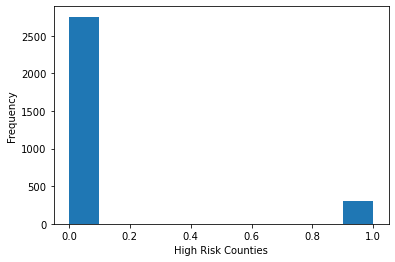

In [14]:
# frequency histogram to see how many counties are high risk and low risk
plt.hist(df["case_class_high"])
plt.xlabel("High Risk Counties")
plt.ylabel("Frequency")
plt.show()

In [15]:
#split data for training and testing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3 ,random_state= 78) 

In [16]:
# Determine the shape of our training and testing sets.
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2140, 103)
(918, 103)
(2140,)
(918,)


In [17]:
# Creating a StandardScaler instance.
scaler = StandardScaler()
# Fitting the Standard Scaler with the training data.
X_scaler = scaler.fit(X_train)

# Scaling the data.
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [18]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state = 42)

In [19]:
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [20]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 150, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [150, 355, 561, 766, 972, 1177, 1383, 1588, 1794, 2000]}


In [21]:
from sklearn.model_selection import RandomizedSearchCV

# Use the random grid to search for best hyperparameters
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=2000; total time=  38.6s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=766; total time=  21.1s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=766; total time=  15.6s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=561; total time=  12.6s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1794; total time= 8.9min
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=766; total time=  31.3s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=

[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=2000; total time=  38.8s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=766; total time=  21.5s
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=972; total time=  21.3s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=972; total time= 4.7min
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=355; total time= 1.7min
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=766; total time=  35.5s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=766; total time=  34.1s
[CV] END bootstrap=False, max_depth=10, 

[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=355; total time=   8.1s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1177; total time=  29.6s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1588; total time=  28.0s
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=972; total time=  20.1s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=972; total time= 3.5min
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1794; total time= 8.3min
[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1794; total time=25.0min
[CV] END bootstrap=True, max_depth=2

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [150, 355, 561, 766,
                                                         972, 1177, 1383, 1588,
                                                         1794, 2000]},
                   random_state=42, verbose=2)

In [22]:
#view best parameters 
rf_random.best_params_

{'n_estimators': 1177,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 20,
 'bootstrap': False}

In [23]:
# to ignore division errors for zeros
np.seterr(invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [24]:
#check zeros in y_test
zeros = np.where(y_test ==0)
print(zeros)

(array([  0,   1,   2,   3,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  25,  26,  27,  28,
        29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  41,  42,
        43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
        56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  68,  69,
        70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  81,  82,  83,
        84,  85,  86,  87,  90,  92,  93,  94,  95,  96,  97,  98,  99,
       100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 113,
       114, 115, 116, 117, 118, 119, 120, 121, 123, 124, 125, 126, 127,
       128, 129, 130, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
       142, 143, 144, 145, 146, 147, 148, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       170, 171, 172, 173, 174, 175, 177, 178, 179, 180, 181, 182, 183,
       184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 1

In [25]:
#check for zeros
n_zeros= zeros[0].size
print (n_zeros)

829


In [26]:
# evaluate random search 


def evaluate(model, test_features, test_labels):
    predictions = model.predict(X_test_scaled)
    errors = abs(predictions - y_test)
    mape = 100 * np.mean(errors / len(y_test))
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

base_model = RandomForestRegressor(n_estimators = 100, random_state = 42)
base_model.fit(X_train_scaled, y_train)
base_accuracy = evaluate(base_model, X_test_scaled, y_test)

Model Performance
Average Error: 0.1686 degrees.
Accuracy = 99.98%.


In [27]:
# evaluate performance with best_random estimator
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test_scaled, y_test)

Model Performance
Average Error: 0.1580 degrees.
Accuracy = 99.98%.


In [28]:
# print the improvement 
print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))


Improvement of 0.00%.
